# Prediction Comparison for UNet Versions

This plots the model segmentation predictions versus the ground truth.

We need to compare the model outputs based on doing the **up sampling operation** via:
+ [UpSampling2D](https://keras.io/layers/convolutional/#upsampling2d)
   ```
   up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=-1)
   ```
+ [Conv2DTranspose](https://keras.io/layers/convolutional/#conv2dtranspose)
   ```
   up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=-1)
   ```
   
Intel has optimized the operations for Conv2DTranspose but not for UpSampling2D. If we can prove that the two produce similar results, then we can recommend the Intel optimization as a viable substitution.

In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def dice(im1, im2):
    
    '''
    Do we match the binary version of the prediction mask or the probability version?
    '''
    
    im1 = np.asarray(im1)
    im2 = np.asarray(im2)

    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")

    # Compute Dice coefficient
    intersection = im1*im2

    smoothing_delta = 1e-7
    
    return (2. * intersection.sum() + smoothing_delta) / (im1.sum() + im2.sum() + smoothing_delta)

# Loading the prediction masks and the ground truth data

The *pred.npy* files were generated by running:
```
numactl -p 1 python train.py 50 5 0
```

In [3]:
msk_upsampling = np.load('msks_pred_upsampling.npy')
msk_transposed = np.load('msks_pred_transposed.npy')
dir1 = '/mnt/data/medical/brats/all_slices/Results/'
test = np.load(dir1+'msks_test.npy')
imgs = np.load(dir1+'imgs_test.npy')

In [4]:
# Preprocess the segmentation masks for the ground truth (mode=1)
test[:,:,:,0] = test[:,:,:,0]+test[:,:,:,1]+test[:,:,:,2]+test[:,:,:,3]

In [5]:
def comparePredictions(img):
    
    plt.figure(figsize=(14,14))
    plt.subplot(1,4,1)
    plt.imshow(msk_upsampling[img,:,:,0], cmap='bone')
    plt.title('Prediction UpSampling')
    plt.subplot(1,4,2)
    plt.imshow(msk_transposed[img,:,:,0], cmap='bone')
    plt.title('Prediction Transposed')
    plt.subplot(1,4,3)
    plt.imshow(test[img,:,:,0], cmap='bone')
    plt.title('Ground truth');
    plt.subplot(1,4,4)
    plt.imshow(imgs[img,:,:,0], cmap='bone')
    plt.imshow(test[img,:,:,0], alpha=0.5)
    
    # Calculate the Dice coefficient for the two versions
    msk_binaryU = msk_upsampling[img,:,:,0]
    print ('Dice coefficient for upsampling {}'.format(dice(msk_binaryU, test[img,:,:,0])))
    
    msk_binaryT = msk_transposed[img,:,:,0]
    print ('Dice coefficient for transposed {}'.format(dice(msk_binaryT, test[img,:,:,0])))
    

Dice coefficient for upsampling 0.7455584529
Dice coefficient for transposed 0.784212602721


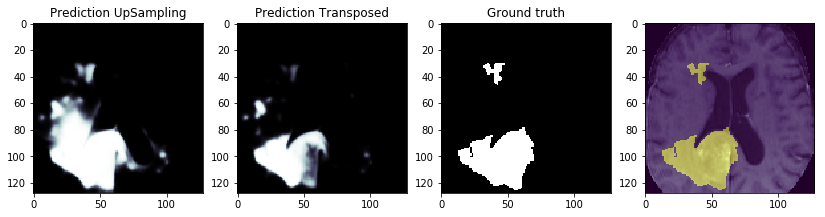

In [6]:
comparePredictions(5821)

Dice coefficient for upsampling 0.856650870366
Dice coefficient for transposed 0.861712757377


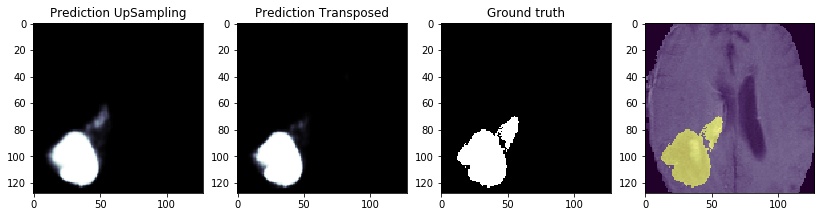

In [7]:
comparePredictions(400)

Dice coefficient for upsampling 0.772312131338
Dice coefficient for transposed 0.751448283117


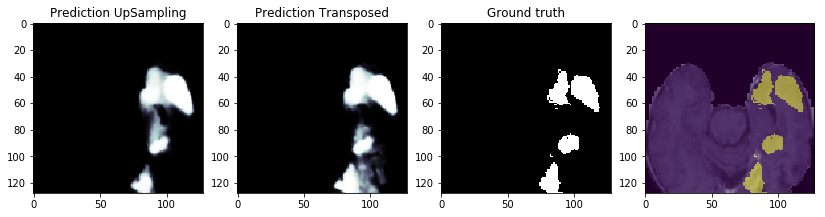

In [8]:
comparePredictions(520)

Dice coefficient for upsampling 0.966550686342
Dice coefficient for transposed 0.970561852823


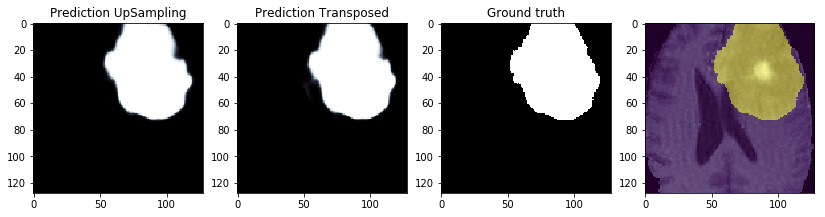

In [9]:
comparePredictions(1333)

Dice coefficient for upsampling 0.903531117429
Dice coefficient for transposed 0.904429251814


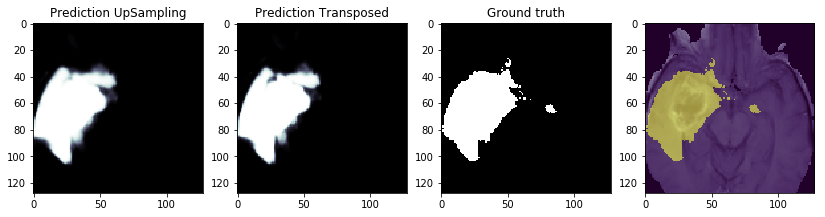

In [10]:
comparePredictions(2540)

Dice coefficient for upsampling 0.63818501566
Dice coefficient for transposed 0.695046446004


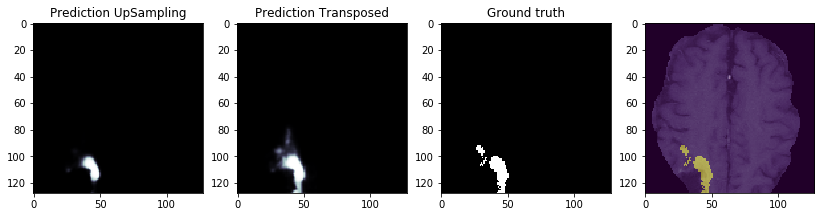

In [11]:
comparePredictions(5533)

Dice coefficient for upsampling 0.922661375229
Dice coefficient for transposed 0.923871812712


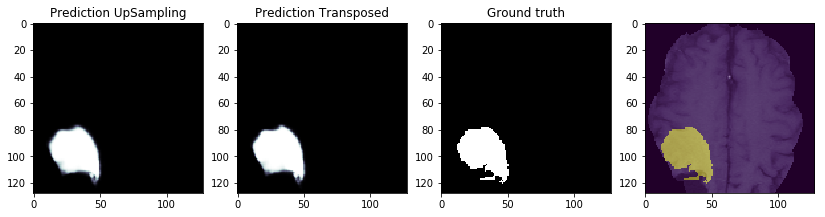

In [12]:
comparePredictions(2121)

Dice coefficient for upsampling 0.910127223112
Dice coefficient for transposed 0.915037730188


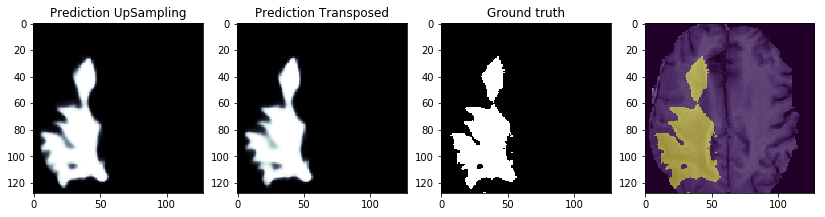

In [13]:
comparePredictions(4444)

Dice coefficient for upsampling 0.835873126032
Dice coefficient for transposed 0.812363848154


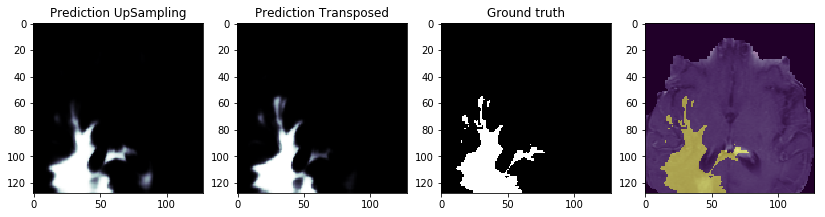

In [14]:
comparePredictions(3334)

Dice coefficient for upsampling 0.849122605766
Dice coefficient for transposed 0.856773215945


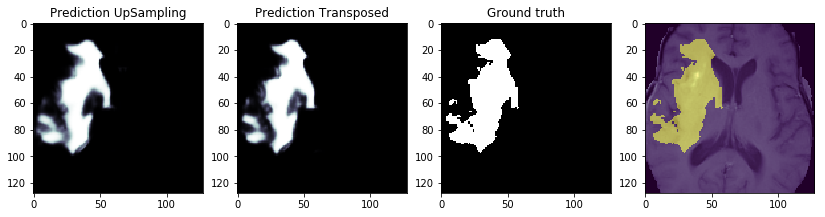

In [15]:
comparePredictions(2560)

Dice coefficient for upsampling 8.32162542194e-05
Dice coefficient for transposed 2.16929071442e-05


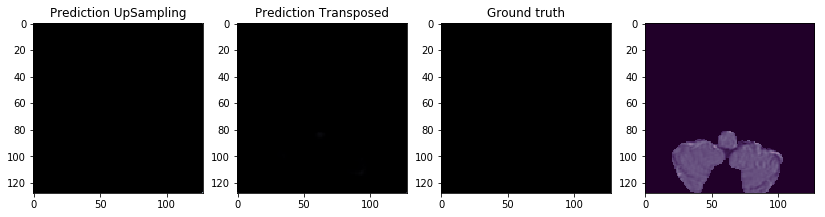

In [16]:
comparePredictions(10)

Dice coefficient for upsampling 0.35678071885
Dice coefficient for transposed 0.259573675957


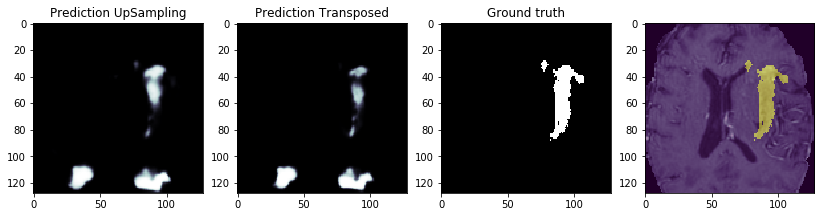

In [17]:
comparePredictions(88)

Dice coefficient for upsampling 5.99780041453e-05
Dice coefficient for transposed 2.15979518283e-05


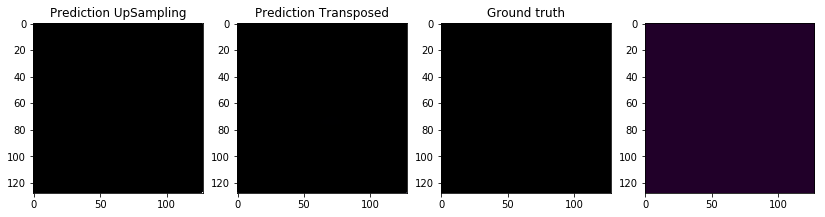

In [18]:
comparePredictions(150)

Dice coefficient for upsampling 0.628281311028
Dice coefficient for transposed 0.580890442165


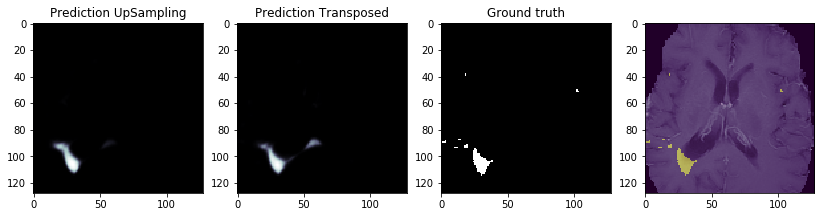

In [19]:
comparePredictions(231)

In [20]:
dice_transposed = np.zeros(test.shape[0])
dice_upsampling = np.zeros(test.shape[0])

for i in range(test.shape[0]):
    
    dice_transposed[i] = dice(msk_transposed[i, :, :, 0], test[i, :, :, 0])
    dice_upsampling[i] = dice(msk_upsampling[i, :, :, 0], test[i, :, :, 0])
    

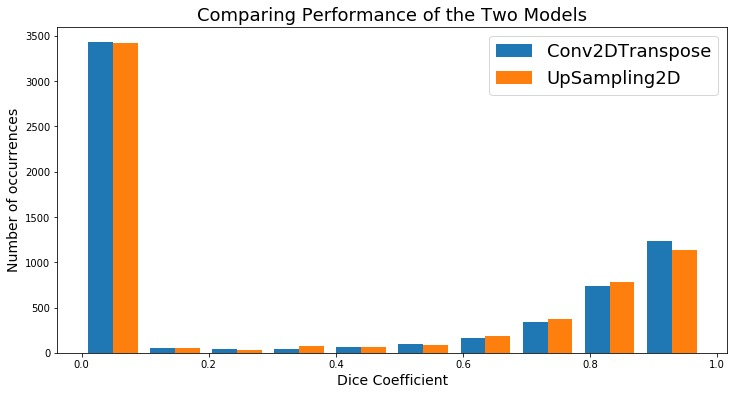

In [21]:
plt.figure(figsize=(12,6));
plt.hist([dice_transposed, dice_upsampling]);
plt.legend(['Conv2DTranspose', 'UpSampling2D'], fontsize=18);
plt.title('Comparing Performance of the Two Models', fontsize=18);
plt.xlabel('Dice Coefficient', fontsize=14);
plt.ylabel('Number of occurrences', fontsize=14);

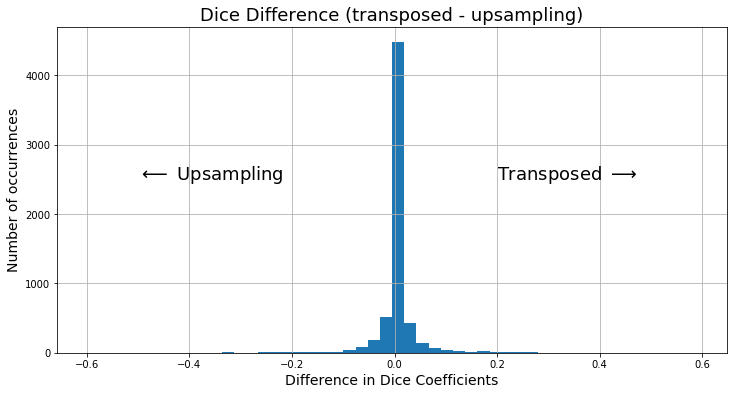

In [22]:
plt.figure(figsize=(12,6));
plt.hist(dice_transposed - dice_upsampling, 50);
plt.title('Dice Difference (transposed - upsampling)', fontsize=18);
plt.text(0.2, 2500, r'Transposed $\longrightarrow$', fontsize=18);
plt.text(-.5, 2500, r'$\longleftarrow$ Upsampling', fontsize=18);
plt.xlabel('Difference in Dice Coefficients', fontsize=14);
plt.ylabel('Number of occurrences', fontsize=14)
plt.grid();

# Kolmogorov-Smirnoff (KS) Test

Perform a [Kolmogorov-Smirnov](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test#Two-sample_Kolmogorov.E2.80.93Smirnov_test) two sample test. The null hypothesis is that the two data samples come from the same distribution. 

In [23]:
from scipy.stats import ks_2samp

ks_2samp(dice_transposed, dice_upsampling)

Ks_2sampResult(statistic=0.17387096774193556, pvalue=3.4906420682330985e-82)

So by the KS statistic, then these two methods have generated the same prediction masks ($p < {1e}^{-81}$).